In [26]:
from mxnet.gluon import loss as gloss, nn, utils as gutils
from mxnet import autograd, nd, sym, gluon, init, image, contrib
import mxnet as mx
import d2lzh as d2l
# import random
# import subprocess
import tarfile
import time
import sys
import os 

# 09. 计算机视觉

## 9.6 目标检测数据集(皮卡丘)
在目标检测领域并没有类似`MNIST`或`Fashion-MNIST`那样的小数据集。为了快速测试模型，我们合成了一个小的数据集。我们首先使用一个开源的皮卡丘3D模型生成了1,000张不同角度和大小的皮卡丘图像。然后我们收集了一系列背景图像，并在每张图的随机位置放置一张随机的皮卡丘图像。我们使用MXNet提供的`im2rec`工具将图像转换成二进制的`RecordIO`格式。该格式既可以降低数据集在磁盘上的存储开销，又能提高读取效率。如果想了解更多的图像读取方法，可以查阅`GluonCV`工具包的文档。

### 9.6.1 获取数据集
`RecordIO`格式的皮卡丘数据集可以直接在网上下载。获取数据集的操作定义在`_download_pikachu`函数中。

In [2]:
def _download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/') 
    dataset = {
        'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
        'train.idx': 'dcf7318b2602c06428b9988470c731621716c393', 
        'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'
    } 
    for k, v in dataset.items():
        gutils.download(root_url + k, os.path.join(data_dir, k), sha1_hash=v)

### 9.6.2 读取数据集
我们通过创建`ImageDetIter`实例来读取目标检测数据集。其中名称里的`Det`指的是`Detection`(检测)。我们将以随机顺序读取训练数据集。由于数据集的格式为`RecordIO`，我们需要提供图像索引文件`train.idx`以随机读取小批量。此外，对于训练集中的每张图像，我们将采用随机裁剪，并要求裁剪出的图像至少覆盖每个目标95%的区域。由于裁剪是随机的，这个要求不一定总被满足。我们设定最多尝试200次随机裁剪：如果都不符合要求则不裁剪图像。为保证输出结果的确定性，我们不随机裁剪测试数据集中的图像。我们也无须按随机顺序读取测试数据集。

In [3]:
# 本函数已保存在d2lzh包中方便以后使用
def load_data_pikachu(batch_size, edge_size=256):  # edge_size：输出图像的宽和高
    data_dir = './data/pikachu'
    _download_pikachu(data_dir)
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'),
        path_imgidx=os.path.join(data_dir, 'train.idx'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),  # 输出图像的形状
        shuffle=True,  # 以随机顺序读取数据集
        rand_crop=1,  # 随机裁剪的概率为1
        min_object_covered=0.95, max_attempts=200)
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'val.rec'), batch_size=batch_size,
        data_shape=(3, edge_size, edge_size), shuffle=False)
    return train_iter, val_iter

下面我们读取一个小批量并打印图像和标签的形状。图像的形状和之前实验中的一样，依然是`(批量大小, 通道数, 高, 宽)`。而标签的形状则是`(批量大小, m, 5)`，其中$m$等于数据集中单个图像最多含有的边界框个数。小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。由于每张图像含有的边界框个数可能不同，我们为边界框个数小于$m$的图像填充非法边界框，直到每张图像均含有$m$个边界框。这样，我们就可以每次读取小批量的图像了。图像中每个边界框的标签由长度为5的数组表示。数组中第一个元素是边界框所含目标的类别。当值为-1时，该边界框为填充用的非法边界框。数组的剩余4个元素分别表示边界框左上角的$x$和$y$轴坐标以及右下角的$x$和$y$轴坐标（值域在0到1之间）。这里的皮卡丘数据集中每个图像只有一个边界框，因此$m=1$。

In [4]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_pikachu(batch_size, edge_size) 
batch = train_iter.next() 
batch.data[0].shape, batch.label[0].shape

((32, 3, 256, 256), (32, 1, 5))

### 9.6.3 图示数据
我们画出10张图像和它们中的边界框。可以看到，皮卡丘的角度、大小和位置在每张图像中都不一样。当然，这是一个简单的人工数据集。实际中的数据通常会复杂得多。

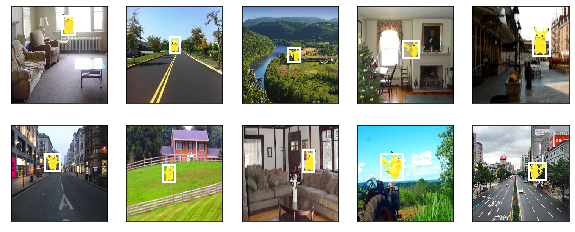

In [5]:
imgs = (batch.data[0][0:10].transpose((0, 2, 3, 1))) / 255
axes = d2l.show_images(imgs, 2, 5).flatten()
for ax, label in zip(axes, batch.label[0][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## 9.7 单发多框检测（SSD）
我们在前几节分别介绍了边界框、锚框、多尺度目标检测和数据集，下面我们基于这些背景知识来构造一个目标检测模型：`单发多框检测`(single shot multibox detection，SSD)。它简单、快速，并得到了广泛应用。该模型的一些设计思想和实现细节常适用于其他目标检测模型。

### 9.7.1 定义模型
`图9.4`描述了单发多框检测模型的设计。它主要由一个基础网络块和若干个多尺度特征块串联而成。其中基础网络块用来从原始图像中抽取特征，因此一般会选择常用的深度卷积神经网络。单发多框检测论文中选用了在分类层之前截断的`VGG`，现在也常用`ResNet`替代。我们可以设计基础网络，使它输出的高和宽较大。这样一来，基于该特征图生成的锚框数量较多，可以用来检测尺寸较小的目标。接下来的每个多尺度特征块将上一层提供的特征图的高和宽缩小(如减半)，并使特征图中每个单元在输入图像上的感受野变得更广阔。如此一来，`图9.4`中越靠近顶部的多尺度特征块输出的特征图越小，故而基于特征图生成的锚框也越少，加之特征图中每个单元感受野越大，因此更适合检测尺寸较大的目标。由于单发多框检测基于基础网络块和各个多尺度特征块生成不同数量和不同大小的锚框，并通过预测锚框的类别和偏移量(即预测边界框)检测不同大小的目标，因此单发多框检测是一个多尺度的目标检测模型。

<img src="images/09_04.png" style="width:600px;"/>

接下来我们介绍如何实现图中的各个模块。我们先介绍如何实现类别预测和边界框预测。

##### 类别预测层

设目标的类别个数为$q$。每个锚框的类别个数将是$q+1$，其中类别0表示锚框只包含背景。在某个尺度下，设特征图的高和宽分别为$h$和$w$，如果以其中每个单元为中心生成$a$个锚框，那么我们需要对$hwa$个锚框进行分类。如果使用全连接层作为输出，很容易导致模型参数过多。回忆“网络中的网络(NiN)”一节介绍的使用卷积层的通道来输出类别预测的方法。单发多框检测采用同样的方法来降低模型复杂度。

具体来说，类别预测层使用一个保持输入高和宽的卷积层。这样一来，输出和输入在特征图宽和高上的空间坐标一一对应。考虑输出和输入同一空间坐标$(x,y)$：输出特征图上$(x,y)$坐标的通道里包含了以输入特征图$(x,y)$坐标为中心生成的所有锚框的类别预测。因此输出通道数为$a(q+1)$，其中索引为$i(q+1) + j$（$0 \leq j \leq q$）的通道代表了索引为$i$的锚框有关类别索引为$j$的预测。

下面我们定义一个这样的类别预测层：指定参数$a$和$q$后，它使用一个填充为1的$3\times3$卷积层。该卷积层的输入和输出的高和宽保持不变。

In [6]:
def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3, padding=1)

##### 边界框预测层
边界框预测层的设计与类别预测层的设计类似。唯一不同的是，这里需要为每个锚框预测4个偏移量，而不是$q+1$个类别。

In [7]:
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)

##### 连结多尺度的预测
前面提到，单发多框检测根据多个尺度下的特征图生成锚框并预测类别和偏移量。由于每个尺度上特征图的形状或以同一单元为中心生成的锚框个数都可能不同，因此不同尺度的预测输出形状可能不同。

在下面的例子中，我们对同一批量数据构造两个不同尺度下的特征图`Y1`和`Y2`，其中`Y2`相对于`Y1`来说高和宽分别减半。以类别预测为例，假设以`Y1`和`Y2`特征图中每个单元生成的锚框个数分别是5和3，当目标类别个数为10时，类别预测输出的通道数分别为$5\times(10+1)=55$和$3\times(10+1)=33$。预测输出的格式为`(批量大小, 通道数, 高, 宽)`。可以看到，除了批量大小外，其他维度大小均不一样。我们需要将它们变形成统一的格式并将多尺度的预测连结，从而让后续计算更简单。

In [8]:
def forward(x, block):
    block.initialize()
    return block(x)

Y1 = forward(nd.zeros((2, 8, 20, 20)), cls_predictor(5, 10))
Y2 = forward(nd.zeros((2, 16, 10, 10)), cls_predictor(3, 10))
(Y1.shape, Y2.shape)

((2, 55, 20, 20), (2, 33, 10, 10))

通道维包含中心相同的锚框的预测结果。我们首先将通道维移到最后一维。因为不同尺度下批量大小仍保持不变，我们可以将预测结果转成二维的`(批量大小, 高X宽X通道数)`的格式，以方便之后在维度1上的连结。

In [9]:
def flatten_pred(pred):
    return pred.transpose((0, 2, 3, 1)).flatten()

def concat_preds(preds):
    return nd.concat(*[flatten_pred(p) for p in preds], dim=1)

这样一来，尽管`Y1`和`Y2`形状不同，我们仍然可以将这两个同一批量不同尺度的预测结果连结在一起。

In [10]:
concat_preds([Y1, Y2]).shape

(2, 25300)

##### 高和宽减半块
为了在多尺度检测目标，下面定义高和宽减半块`down_sample_blk`。它串联了两个填充为`1`的$3\times3$卷积层和步幅为`2`的$2\times2$最大池化层。我们知道，填充为`1`的$3\times3$卷积层不改变特征图的形状，而后面的池化层则直接将特征图的高和宽减半。由于$1\times 2+(3-1)+(3-1)=6$，输出特征图中每个单元在输入特征图上的感受野形状为$6\times6$。可以看出，高和宽减半块使输出特征图中每个单元的感受野变得更广阔。

In [11]:
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(
            nn.Conv2D(num_channels, kernel_size=3, padding=1),
            nn.BatchNorm(in_channels=num_channels),
            nn.Activation('relu'))
    blk.add(nn.MaxPool2D(2))
    return blk

测试高和宽减半块的前向计算。可以看到，它改变了输入的通道数，并将高和宽减半。

In [12]:
forward(nd.zeros((2, 3, 20, 20)), down_sample_blk(10)).shape

(2, 10, 10, 10)

##### 基础网络块
基础网络块用来从原始图像中抽取特征。为了计算简洁，我们在这里构造一个小的基础网络。该网络串联3个高和宽减半块，并逐步将通道数翻倍。当输入的原始图像的形状为$256\times256$时，基础网络块输出的特征图的形状为$32 \times 32$。

In [13]:
def base_net():
    blk = nn.Sequential()
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    return blk

forward(nd.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

##### 完整的模型
单发多框检测模型一共包含5个模块，每个模块输出的特征图既用来生成锚框，又用来预测这些锚框的类别和偏移量。第一模块为基础网络块，第二模块至第四模块为高和宽减半块，第五模块使用全局最大池化层将高和宽降到1。因此第二模块至第五模块均为`图9.4`中的多尺度特征块。

In [14]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk

接下来，我们定义每个模块如何进行前向计算。与之前介绍的卷积神经网络不同，这里不仅返回卷积计算输出的特征图`Y`，还返回根据`Y`生成的当前尺度的锚框，以及基于`Y`预测的锚框类别和偏移量。

In [15]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = contrib.ndarray.MultiBoxPrior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

我们提到，`图9.4`中较靠近顶部的多尺度特征块用来检测尺寸较大的目标，因此需要生成较大的锚框。我们在这里先将0.2到1.05之间均分5份，以确定不同尺度下锚框大小的较小值0.2、0.37、0.54等，再按$\sqrt{0.2 \times 0.37} = 0.272$、$\sqrt{0.37 \times 0.54} = 0.447$等来确定不同尺度下锚框大小的较大值。

In [16]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

现在，我们就可以定义出完整的模型`TinySSD`了。

In [17]:
class TinySSD(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        for i in range(5):
            # 即赋值语句self.blk_i = get_blk(i)
            setattr(self, 'blk_%d' % i, get_blk(i))
            setattr(self, 'cls_%d' % i, cls_predictor(num_anchors, num_classes))
            setattr(self, 'bbox_%d' % i, bbox_predictor(num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self, 'blk_%d' % i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(X, getattr(self, 'blk_%d' % i), sizes[i], ratios[i], 
                                                                     getattr(self, 'cls_%d' % i), getattr(self, 'bbox_%d' % i))
        # reshape函数中的0表示保持批量大小不变
        return (nd.concat(*anchors, dim=1), concat_preds(cls_preds).reshape((0, -1, self.num_classes + 1)), concat_preds(bbox_preds))

我们创建单发多框检测模型实例并对一个高和宽均为256像素的小批量图像X做前向计算。我们在之前验证过，第一模块输出的特征图的形状为$32 \times 32$。由于第二至第四模块为高和宽减半块、第五模块为全局池化层，并且以特征图每个单元为中心生成4个锚框，每个图像在5个尺度下生成的锚框总数为$(32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444$。

In [18]:
net = TinySSD(num_classes=1)
net.initialize()
X = nd.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: (1, 5444, 4)
output class preds: (32, 5444, 2)
output bbox preds: (32, 21776)


### 9.7.2 训练模型
下面我们描述如何一步步训练单发多框检测模型来进行目标检测。

##### 读取数据集和初始化
我们读取"目标检测数据集(皮卡丘)"一节构造的皮卡丘数据集。

In [19]:
batch_size = 32
train_iter, _ = load_data_pikachu(batch_size)

在皮卡丘数据集中，目标的类别数为1。定义好模型以后，我们需要初始化模型参数并定义优化算法。

In [20]:
# ctx, net = d2l.try_gpu(), TinySSD(num_classes=1)
ctx, net = mx.cpu(), TinySSD(num_classes=1)
net.initialize(init=init.Xavier(), ctx=ctx) 
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.2, 'wd': 5e-4})

##### 定义损失函数和评价函数
目标检测有两个损失：
+ 有关锚框类别的损失，我们可以重用之前图像分类问题里一直使用的交叉熵损失函数
+ 有关正类锚框偏移量的损失。预测偏移量是一个回归问题，但这里不使用前面介绍过的平方损失，而使用$L_1$范数损失，即预测值与真实值之间差的绝对值

掩码变量`bbox_masks`令负类锚框和填充锚框不参与损失的计算。最后，我们将有关锚框类别和偏移量的损失相加得到模型的最终损失函数。

In [21]:
cls_loss = gloss.SoftmaxCrossEntropyLoss()
bbox_loss = gloss.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox

我们可以沿用准确率评价分类结果。因为使用了$L_1$范数损失，我们用平均绝对误差评价边界框的预测结果。

In [22]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维
    return (cls_preds.argmax(axis=-1) == cls_labels).sum().asscalar()

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return ((bbox_labels - bbox_preds) * bbox_masks).abs().sum().asscalar()

##### 训练模型
在训练模型时，我们需要在模型的前向计算过程中生成多尺度的锚框`anchors`，并为每个锚框预测类别`cls_preds`和偏移量`bbox_preds`。之后，我们根据标签信息`Y`为生成的每个锚框标注类别`cls_labels`和偏移量`bbox_labels`。最后，我们根据类别和偏移量的预测和标注值计算损失函数。为了代码简洁，这里没有评价测试数据集。

```python
for epoch in range(20):
    acc_sum, mae_sum, n, m = 0.0, 0.0, 0, 0
    train_iter.reset()  # 从头读取数据
    start = time.time()
    for batch in train_iter:
        X = batch.data[0].as_in_context(ctx)
        Y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            # 生成多尺度的锚框，为每个锚框预测类别和偏移量
            anchors, cls_preds, bbox_preds = net(X)
            # 为每个锚框标注类别和偏移量
            bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(anchors, Y, cls_preds.transpose((0, 2, 1)))
            # 根据类别和偏移量的预测和标注值计算损失函数
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.backward()
        trainer.step(batch_size)
        acc_sum += cls_eval(cls_preds, cls_labels)
        n += cls_labels.size
        mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        m += bbox_labels.size

    if (epoch + 1) % 5 == 0:
        print('epoch %2d, class err %.2e, bbox mae %.2e, time %.1f sec' % (epoch + 1, 1 - acc_sum / n, mae_sum / m, time.time() - start))
```

### 9.7.3 预测目标
在预测阶段，我们希望能把图像里面所有我们感兴趣的目标检测出来。下面读取测试图像，将其变换尺寸，然后转成卷积层需要的四维格式。

```python
img = image.imread('./data/image/pikachu.jpg')
feature = image.imresize(img, 256, 256).astype('float32')
X = feature.transpose((2, 0, 1)).expand_dims(axis=0)
```

我们通过`MultiBoxDetection`函数根据锚框及其预测偏移量得到预测边界框，并通过非极大值抑制移除相似的预测边界框。

```python
def predict(X):
    anchors, cls_preds, bbox_preds = net(X.as_in_context(ctx))
    cls_probs = cls_preds.softmax().transpose((0, 2, 1))
    output = contrib.nd.MultiBoxDetection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0].asscalar() != -1]
    return output[0, idx]

output = predict(X)
```

最后，我们将置信度不低于0.3的边界框筛选为最终输出用以展示。

```python
d2l.set_figsize((5, 5))

def display(img, output, threshold):
    fig = d2l.plt.imshow(img.asnumpy())
    for row in output:
        score = row[1].asscalar()
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * nd.array((w, h, w, h), ctx=row.context)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output, threshold=0.3)
```

## 9.8 区域卷积神经网络(R-CNN)系列
区域卷积神经网络(region-based CNN或regions with CNN features，R-CNN)是将深度模型应用于目标检测的开创性工作之一。在本节中，我们将介绍R-CNN和它的一系列改进方法：快速的R-CNN(Fast R-CNN)、更快的R-CNN(Faster R-CNN)以及掩码R-CNN(Mask R-CNN)。限于篇幅，这里只介绍这些模型的设计思路。

### 9.8.1 R-CNN
R-CNN首先对图像选取若干提议区域(如锚框也是一种选取方法)并标注它们的类别和边界框(如偏移量)。然后，用卷积神经网络对每个提议区域做前向计算抽取特征。之后，我们用每个提议区域的特征预测类别和边界框。

`图9.5`描述了R-CNN模型。

<img src="images/09_05.png" style="width:600px;"/>

具体来说，R-CNN主要由以下4步构成：
1. 对输入图像使用选择性搜索(selective search)来选取多个高质量的提议区域。这些提议区域通常是在多个尺度下选取的，并具有不同的形状和大小。每个提议区域将被标注类别和真实边界框
2. 选取一个预训练的卷积神经网络，并将其在输出层之前截断。将每个提议区域变形为网络需要的输入尺寸，并通过前向计算输出抽取的提议区域特征
3. 将每个提议区域的特征连同其标注的类别作为一个样本，训练多个支持向量机对目标分类。其中每个支持向量机用来判断样本是否属于某一个类别
4. 将每个提议区域的特征连同其标注的边界框作为一个样本，训练线性回归模型来预测真实边界框

R-CNN虽然通过预训练的卷积神经网络有效抽取了图像特征，但它的主要缺点是速度慢。想象一下，我们可能从一张图像中选出上千个提议区域，对该图像做目标检测将导致上千次的卷积神经网络的前向计算。这个巨大的计算量令R-CNN难以在实际应用中被广泛采用。

### 9.8.2 Fast R-CNN
R-CNN的主要性能瓶颈在于需要对每个提议区域独立抽取特征。由于这些区域通常有大量重叠，独立的特征抽取会导致大量的重复计算。Fast R-CNN对R-CNN的一个主要改进在于只对整个图像做卷积神经网络的前向计算。

`图9.6`描述了Fast R-CNN模型。

<img src="images/09_06.png" style="width:350px;"/>

它的主要计算步骤如下：
1. 与R-CNN相比，Fast R-CNN用来提取特征的卷积神经网络的输入是整个图像，而不是各个提议区域。而且，这个网络通常会参与训练，即更新模型参数。设输入为一张图像，将卷积神经网络的输出的形状记为$1 \times c \times h_1 \times w_1$
2. 假设选择性搜索生成$n$个提议区域。这些形状各异的提议区域在卷积神经网络的输出上分别标出形状各异的兴趣区域。这些兴趣区域需要抽取出形状相同的特征(假设高和宽均分别指定为$h_2$和$w_2$)以便于连结后输出。Fast R-CNN引入兴趣区域池化(region of interest pooling，RoI池化)层，将卷积神经网络的输出和提议区域作为输入，输出连结后的各个提议区域抽取的特征，形状为$n \times c \times h_2 \times w_2$
3. 通过全连接层将输出形状变换为$n \times d$，其中超参数$d$取决于模型设计
4. 预测类别时，将全连接层的输出的形状再变换为$n \times q$并使用softmax回归($q$为类别个数)。预测边界框时，将全连接层的输出的形状变换为$n \times 4$。也就是说，我们为每个提议区域预测类别和边界框

Fast R-CNN中提出的兴趣区域池化层与我们在“池化层”一节介绍过的池化层有所不同。在池化层中，我们通过设置池化窗口、填充和步幅来控制输出形状。而兴趣区域池化层对每个区域的输出形状是可以直接指定的，例如，指定每个区域输出的高和宽分别为$h_2$和$w_2$。假设某一兴趣区域窗口的高和宽分别为$h$和$w$，该窗口将被划分为形状为$h_2 \times w_2$的子窗口网格，且每个子窗口的大小大约为$(h/h_2) \times (w/w_2)$。任一子窗口的高和宽要取整，其中的最大元素作为该子窗口的输出。因此，兴趣区域池化层可从形状各异的兴趣区域中均抽取出形状相同的特征。

`图9.7`中，我们在$4 \times 4$的输入上选取了左上角的$3\times 3$区域作为兴趣区域。对于该兴趣区域，我们通过$2\times 2$兴趣区域池化层得到一个$2\times 2$的输出。4个划分后的子窗口分别含有元素0、1、4、5(5最大)，2、6(6最大)，8、9(9最大)，10。

<img src="images/09_07.png" style="width:350px;"/>

我们使用`ROIPooling`函数来演示兴趣区域池化层的计算。假设卷积神经网络抽取的特征X的高和宽均为4且只有单通道。

In [23]:
X = nd.arange(16).reshape((1, 1, 4, 4))
X


[[[[ 0.  1.  2.  3.]
   [ 4.  5.  6.  7.]
   [ 8.  9. 10. 11.]
   [12. 13. 14. 15.]]]]
<NDArray 1x1x4x4 @cpu(0)>

假设图像的高和宽均为40像素。再假设选择性搜索在图像上生成了两个提议区域：每个区域由5个元素表示，分别为区域目标类别、左上角的$x$和$y$轴坐标以及右下角的$x$和$y$轴坐标。

In [24]:
rois = nd.array([[0, 0, 0, 20, 20], [0, 0, 10, 30, 30]])

由于X的高和宽是图像的高和宽的$1/10$，以上两个提议区域中的坐标先按spatial_scale自乘0.1，然后在X上分别标出兴趣区域`X[:,:,0:3,0:3]`和`X[:,:,1:4,0:4]`。最后对这两个兴趣区域分别划分子窗口网格并抽取高和宽为2的特征。

In [25]:
nd.ROIPooling(X, rois, pooled_size=(2, 2), spatial_scale=0.1)


[[[[ 5.  6.]
   [ 9. 10.]]]


 [[[ 9. 11.]
   [13. 15.]]]]
<NDArray 2x1x2x2 @cpu(0)>

### 9.8.3 Faster R-CNN
Fast R-CNN通常需要在选择性搜索中生成较多的提议区域，以获得较精确的目标检测结果。Faster R-CNN提出将选择性搜索替换成区域提议网络(region proposal network)，从而减少提议区域的生成数量，并保证目标检测的精度。

<img src="images/09_08.png" style="width:500px;"/>

图9.8描述了Faster R-CNN模型。与Fast R-CNN相比，只有生成提议区域的方法从选择性搜索变成了区域提议网络，而其他部分均保持不变。具体来说，区域提议网络的计算步骤如下：
1. 使用填充为1的$3\times 3$卷积层变换卷积神经网络的输出，并将输出通道数记为$c$。这样，卷积神经网络为图像抽取的特征图中的每个单元均得到一个长度为$c$的新特征
2. 以特征图每个单元为中心，生成多个不同大小和宽高比的锚框并标注它们
3. 用锚框中心单元长度为$c$的特征分别预测该锚框的二元类别(含目标还是背景)和边界框。
4. 使用非极大值抑制，从预测类别为目标的预测边界框中移除相似的结果。最终输出的预测边界框即兴趣区域池化层所需要的提议区域

值得一提的是，区域提议网络作为Faster R-CNN的一部分，是和整个模型一起训练得到的。也就是说，Faster R-CNN的目标函数既包括目标检测中的类别和边界框预测，又包括区域提议网络中锚框的二元类别和边界框预测。最终，区域提议网络能够学习到如何生成高质量的提议区域，从而在减少提议区域数量的情况下也能保证目标检测的精度。

### 9.8.4 Mask R-CNN
如果训练数据还标注了每个目标在图像上的像素级位置，那么Mask R-CNN能有效利用这些详尽的标注信息进一步提升目标检测的精度。

<img src="images/09_09.png" style="width:350px;"/>

如`图9.9`所示，Mask R-CNN在Faster R-CNN的基础上做了修改。Mask R-CNN将兴趣区域池化层替换成了兴趣区域对齐层，即通过`双线性插值`(bilinear interpolation)来保留特征图上的空间信息，从而更适于像素级预测。兴趣区域对齐层的输出包含了所有兴趣区域的形状相同的特征图。它们既用来预测兴趣区域的类别和边界框，又通过额外的全卷积网络预测目标的像素级位置。我们将在“全卷积网络(FCN)”一节介绍如何使用全卷积网络预测图像中像素级的语义。

## 9.9 语义分割和数据集
本节将探讨`语义分割`(semantic segmentation)问题，它关注如何将图像分割成属于不同语义类别的区域。值得一提的是，这些语义区域的标注和预测都是像素级的。`图9.10`展示了语义分割中图像有关狗、猫和背景的标签。可以看到，与目标检测相比，语义分割标注的像素级的边框显然更加精细。

<img src="images/09_10.png" style="width:350px;"/>

### 9.9.1 图像分割和实例分割
计算机视觉领域还有2个与语义分割相似的重要问题，即`图像分割`(image segmentation)和`实例分割`(instance segmentation)。我们在这里将它们与语义分割简单区分一下：
+ 图像分割将图像分割成若干组成区域。这类问题的方法通常利用图像中像素之间的相关性。它在训练时不需要有关图像像素的标签信息，在预测时也无法保证分割出的区域具有我们希望得到的语义。以`图9.10`的图像为输入，图像分割可能将狗分割成两个区域：一个覆盖以黑色为主的嘴巴和眼睛，而另一个覆盖以黄色为主的其余部分身体
+ 实例分割又叫同时检测并分割(simultaneous detection and segmentation)。它研究如何识别图像中各个目标实例的像素级区域。与语义分割有所不同，实例分割不仅需要区分语义，还要区分不同的目标实例。如果图像中有两只狗，实例分割需要区分像素属于这两只狗中的哪一只

### 9.9.2 Pascal VOC2012语义分割数据集
语义分割的一个重要数据集叫作`Pascal VOC2012`数据集。

In [27]:
# 本函数已保存在d2lzh包中方便以后使用
# 压缩包⼤小是2GB左右，下载需要⼀定时间
def download_voc_pascal(data_dir='./data'):
    voc_dir = os.path.join(data_dir, 'VOCdevkit/VOC2012')
    url = ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar')
    sha1 = '4e443f8a2eca6b1dac8a6c57641b67dd40621a49'
    fname = gutils.download(url, data_dir, sha1_hash=sha1)
    with tarfile.open(fname, 'r') as f:
        f.extractall(data_dir)
    return voc_dir

voc_dir = download_voc_pascal()

download failed due to ConnectionError(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')),), retrying, 4 attempts left
download failed due to ConnectionError(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')),), retrying, 3 attempts left
download failed due to ConnectionError(MaxRetryError("HTTPConnectionPool(host='host.robots.ox.ac.uk', port=80): Max retries exceeded with url: /pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f95fc16ea90>: Failed to establish a new connection: [Errno 110] Connection timed out',))",),), retrying, 2 attempts left
download failed due to ConnectionError(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')),), retrying, 1 attempt left


ConnectionError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))